# Experiment

## Imports

In [55]:
import librosa
import os
import soundfile as sf
import pandas as pd
import json
import numpy as np
import shutil
from sklearn.metrics import confusion_matrix, mean_absolute_error
import seaborn as sn
import matplotlib.pyplot as plt
import json

from preprocessing import get_chunks
from model import CRNN
from util import *

## Paths

In [56]:
DATA_DIR = "../../data/"
INPUT_DIR = os.path.join(DATA_DIR, "test-real/")
OUTPUT_DIR = os.path.join(DATA_DIR, "processed/test-real/")
DATASET_DIR = os.path.join(DATA_DIR, "dataset/")
ANNOTATIONS_DIR = os.path.join(DATA_DIR, "annotations/")
MODEL_DIR = "../models/"
IMAGE_DIR = "../images/"

SCALING_FILE = os.path.join(DATA_DIR, "scaling_parameters.json")
BEST_MODEL = os.path.join(MODEL_DIR, "best_weights.h5")

In [57]:
filenames = ["family_3.m4a", "family_4.m4a", "family_5.m4a", "podcast_3.mp3", "debate_3.wav"]

## Parameters

In [58]:
max_k = 10
sample_rate = 16000
s = 5
test_max_k = 5
preprocessing = False

## Preprocessing

In [59]:
if preprocessing:
    for filename in filenames:
        audio, samplerate = librosa.load(os.path.join(INPUT_DIR, filename), sr=sample_rate)
        chunks = get_chunks(audio, samplerate, s=s)
        
        name = filename[:filename.find(".")]
        output_dir = os.path.join(OUTPUT_DIR, f"{name}/")

        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        for i, chunk in enumerate(chunks):
            sf.write(os.path.join(output_dir, f"{name}_{i:05}.wav"), chunk, samplerate)

## Load Data

In [60]:
annot_files = [filename[:filename.find(".")]+".csv" for filename in filenames]

In [61]:
dfs = []
for annot_file in annot_files:
    df = pd.read_csv(os.path.join(ANNOTATIONS_DIR, annot_file))
    df = df[['audio', 'label']]
    df['label'] = df['label'].apply(json.loads)
    dfs.append(df)

data = pd.concat(dfs)

In [62]:
data.head()

,audio,label
0,/data/upload/1/18260f45-family_3_00011.wav,"[{'start': 0.008417508417508417, 'end': 4.9915..."
1,/data/upload/1/95ccfbc5-family_3_00010.wav,"[{'start': 0.016835016835016835, 'end': 4.9915..."
2,/data/upload/1/15e86196-family_3_00009.wav,"[{'start': 0, 'end': 1.4393939393939394, 'labe..."
3,/data/upload/1/865b1f26-family_3_00008.wav,"[{'start': 0.03367003367003367, 'end': 4.99579..."
4,/data/upload/1/30bc51bf-family_3_00007.wav,"[{'start': -0.004208754208754209, 'end': 4.987..."


In [63]:
len(data)

737

## Compute Labels

In [64]:
k = []
audio_files = []

for i, row in data.iterrows():
    indices = np.zeros(5 * sample_rate)

    for label in row["label"]:
        start = max(round(label['start'] * sample_rate), 0)
        end = round(label['end'] * sample_rate)
        indices[start:end] += 1 

    audio_file = row["audio"][row["audio"].index("-")+1:]
    audio_files.append(audio_file)

    k.append(int(np.max(indices)))

In [65]:
annotated_data = pd.DataFrame({"audio": audio_files, "k": k})

In [66]:
annotated_data.head()

,audio,k
0,family_3_00011.wav,3
1,family_3_00010.wav,3
2,family_3_00009.wav,3
3,family_3_00008.wav,3
4,family_3_00007.wav,3


## Create Test Dataset

### Assign Index

In [67]:
counts = []
for i in range(1, 5+1):
    n_k = len(annotated_data[annotated_data['k'] == i])
    counts.extend(np.arange(n_k))

In [68]:
annotated_data = annotated_data.sort_values(by="k").reset_index(drop=True)
annotated_data["count"] = counts
annotated_data.head()

,audio,k,count
0,debate_3_00000.wav,1,0
1,podcast_3_00133.wav,1,1
2,debate_3_00236.wav,1,2
3,debate_3_00234.wav,1,3
4,debate_3_00233.wav,1,4


### Make Directories

In [69]:
dirs = os.listdir(OUTPUT_DIR)
for directory in dirs:
    dataset_dir = os.path.join(DATASET_DIR, directory)
    if not os.path.exists(dataset_dir):
        os.makedirs(dataset_dir)

### Copy Files and Change File Name

In [70]:
for i, row in annotated_data.iterrows():
    dir_name = row["audio"][:row["audio"].index(".")-6]
    from_path = os.path.join(OUTPUT_DIR, dir_name, row["audio"])
    to_path = os.path.join(DATASET_DIR, dir_name, f"{row['k']:02}_speakers_{row['count']}.wav")
    shutil.copy(from_path, to_path)

## Load Scaling Parameters

In [71]:
with open(SCALING_FILE, 'r') as f:
        scaling_parameters = json.load(f)

mean = scaling_parameters["mean"]
std = scaling_parameters["std"]

In [72]:
print(f"Dataset mean: {mean}")
print(f"Dataset std: {std}")

Dataset mean: 0.0007900168420746922
Dataset std: 0.002085912274196744


## Load Model

In [73]:
model = CRNN((500, 201, 1), max_k)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 498, 199, 64)      640       
                                                                 
 conv2d_5 (Conv2D)           (None, 496, 197, 32)      18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 165, 65, 32)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 163, 63, 128)      36992     
                                                                 
 conv2d_7 (Conv2D)           (None, 161, 61, 64)       73792     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 53, 20, 64)       0         
 2D)                                                  

## Test

### Data Generator

In [74]:
test_files = [f for f in os.listdir(os.path.join(DATASET_DIR, "test-real/")) if f.endswith(".wav")]

In [75]:
test_generator = CustomDataGenerator(os.path.join(DATASET_DIR, "test-real/"), 
                                    test_files, dim=(500, 201), 
                                    max_k=max_k, batch_size=1, 
                                    mean=mean, std=std, 
                                    s=s, train=False, shuffle=False)

### Get Predictions & Labels

In [76]:
model.load_weights(os.path.join(MODEL_DIR, BEST_MODEL))
predictions = model.predict(test_generator)
labels = test_generator.get_classes()
pred = np.argmax(predictions, axis=1)
true = np.argmax(labels, axis=1)

## Analysis

### Image Direcotry

In [77]:
if not os.path.exists(IMAGE_DIR):
    os.makedirs(IMAGE_DIR)

### Confusion Matrix

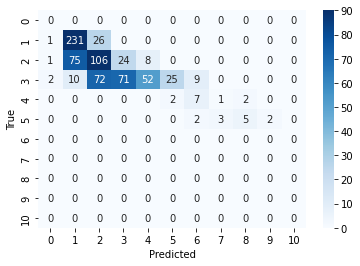

In [78]:
cm = confusion_matrix(true, pred, labels=np.arange(max_k+1))
sn.heatmap(cm, annot=True, fmt="g", cmap="Blues", vmin=0, vmax=90)
plt.ylabel("True")
plt.xlabel("Predicted")
plt.savefig(os.path.join(IMAGE_DIR, "confusion_matrix.png"))
plt.show()

## Mean Absolute Error

In [79]:
mae_scores = []
for i in range(1,test_max_k+1):
    mae = mean_absolute_error(true[true == i], pred[true == i])
    mae_scores.append(mae)

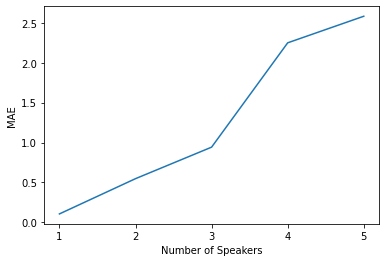

In [80]:
plt.plot(np.arange(1,test_max_k+1), mae_scores)
plt.xlabel("Number of Speakers")
plt.ylabel("MAE")
plt.xticks(np.arange(1,test_max_k+1))
plt.savefig(os.path.join(IMAGE_DIR, "mae.png"))
plt.show()